In [1]:
# read neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import requests
import glob
import datetime
import re
pd.options.display.max_rows = 20
np.set_printoptions(precision = 4, suppress = True)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Dataset preparation

In [3]:
deaths = ("/content/drive/MyDrive/data/covid_deaths_usafacts.csv")
infections = ("/content/drive/MyDrive/data/covid_confirmed_usafacts.csv")
vax = ("/content/drive/MyDrive/data/Vaccine Date NJ.csv")

# loading in pre-filtered data (jupyter suck with large files, cant blame panda for this)
df_deaths = pd.read_csv(deaths)
df_infections = pd.read_csv(infections)
df_vax = pd.read_csv(vax)

In [4]:
# convert date column to panda datatime 
df_vax.Date = pd.to_datetime(df_vax.Date)

In [5]:
# only focus on specific period (until march 1st 2021)
df_vax = df_vax[df_vax['Date'] <= '2021-12-31'].sort_values(by=["Date"]).reset_index(drop=True)

In [6]:
# filter out Unknown County
df_vax = df_vax[df_vax['Recip_County']!="Unknown County"]

In [7]:
df_vax

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Series_Complete_5Plus,Series_Complete_5PlusPop_Pct,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct,Booster_Doses,Booster_Doses_Vax_Pct,Booster_Doses_18Plus,Booster_Doses_18Plus_Vax_Pct,Booster_Doses_50Plus,Booster_Doses_50Plus_Vax_Pct,Booster_Doses_65Plus,Booster_Doses_65Plus_Vax_Pct,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_5PlusPop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_5PlusPop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,2020-12-13,34027,51,Morris County,NJ,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN,NaN,491845.0,NaN,428537.0,389368.0,NaN
1,2020-12-13,34021,51,Mercer County,NJ,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN,NaN,367430.0,NaN,316439.0,289368.0,NaN
2,2020-12-13,34025,51,Monmouth County,NJ,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN,NaN,618795.0,NaN,539254.0,489383.0,NaN
3,2020-12-13,34017,51,Hudson County,NJ,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN,NaN,672391.0,NaN,574459.0,535676.0,NaN
4,2020-12-13,34019,51,Hunterdon County,NJ,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,NaN,0,0.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,Metro,NaN,NaN,NaN,NaN,NaN,124371.0,NaN,110363.0,100659.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8440,2021-12-31,34013,52,Essex County,NJ,93.8,655198.0,82.0,655114.0,87.8,631558.0,94.0,584226.0,95.0,114183.0,95.0,532154,66.6,532147.0,71.3,516436,76.9,476710,78.2,91838,82.7,175449.0,33.0,173072.0,36.3,106767.0,48.2,52580.0,57.3,D,16.0,16.0,16.0,16.0,16.0,Metro,4.0,4.0,4.0,4.0,4.0,798975.0,746491.0,671913.0,609578.0,111102.0
8441,2021-12-31,34005,52,Burlington County,NJ,93.8,367481.0,82.5,367451.0,86.9,354642.0,91.6,331840.0,94.0,80703.0,95.0,314821,70.7,314818.0,74.5,306446,79.2,286217,81.0,69636,90.0,122209.0,38.8,121208.0,42.3,83823.0,55.2,45535.0,65.4,A,4.0,4.0,4.0,4.0,4.0,Metro,4.0,4.0,4.0,4.0,4.0,445349.0,422617.0,387026.0,353190.0,77365.0
8442,2021-12-31,34023,52,Middlesex County,NJ,93.8,682116.0,82.7,682055.0,87.7,657080.0,92.8,608852.0,94.2,130243.0,95.0,564946,68.5,564932.0,72.6,550184,77.7,508172,78.6,106810,83.6,198180.0,35.1,196641.0,38.7,124198.0,51.1,66883.0,62.6,B,8.0,8.0,8.0,8.0,8.0,Metro,4.0,4.0,4.0,4.0,4.0,825062.0,777910.0,708391.0,646270.0,127763.0
8443,2021-12-31,34035,52,Somerset County,NJ,93.8,284621.0,86.5,284596.0,91.0,273966.0,95.0,254777.0,95.0,55450.0,95.0,235474,71.6,235469.0,75.3,228780,80.1,211903,82.1,45420,85.4,96062.0,40.8,95265.0,45.0,61694.0,56.8,30595.0,67.4,A,4.0,4.0,4.0,4.0,4.0,Metro,4.0,4.0,4.0,4.0,4.0,328934.0,312584.0,285695.0,258178.0,53188.0


In [8]:
# filter on NJ (New Jersey) only and ignore first row
df_infections = df_infections[df_infections['State'] == "NJ"].iloc[1: , :].reset_index(drop=True)

In [9]:
# pivot the table in such a way that it has similar structure as the vax_data 
df_infections = df_infections.melt(id_vars=['County Name','State'],
                               value_vars= df_infections.iloc[:,4:],
                               var_name='Date', 
                               value_name='Nr. of infected')

df_infections["County Name"] = df_infections["County Name"].str.rstrip()

In [10]:
df_infections

,County Name,State,Date,Nr. of infected
0,Atlantic County,NJ,2020-01-22,0
1,Bergen County,NJ,2020-01-22,0
2,Burlington County,NJ,2020-01-22,0
3,Camden County,NJ,2020-01-22,0
4,Cape May County,NJ,2020-01-22,0
...,...,...,...,...
15430,Salem County,NJ,2022-01-25,13488
15431,Somerset County,NJ,2022-01-25,63774
15432,Sussex County,NJ,2022-01-25,32028
15433,Union County,NJ,2022-01-25,135824


In [11]:
# filter on NJ (New Jersey) only and ignore first row
df_deaths = df_deaths[df_deaths['State'] == "NJ"].iloc[1: , :].reset_index(drop=True)

In [12]:
# pivot the table in such a way that it has similar structure as the vax_data 
df_deaths = df_deaths.melt(id_vars=['County Name','State'],
                               value_vars= df_deaths.iloc[:,4:],
                               var_name='Date', 
                               value_name='Nr. of deaths')

df_deaths["County Name"] = df_deaths["County Name"].str.rstrip()

In [13]:
df_deaths

,County Name,State,Date,Nr. of deaths
0,Atlantic County,NJ,2020-01-22,0
1,Bergen County,NJ,2020-01-22,0
2,Burlington County,NJ,2020-01-22,0
3,Camden County,NJ,2020-01-22,0
4,Cape May County,NJ,2020-01-22,0
...,...,...,...,...
15430,Salem County,NJ,2022-01-25,228
15431,Somerset County,NJ,2022-01-25,933
15432,Sussex County,NJ,2022-01-25,424
15433,Union County,NJ,2022-01-25,2194


In [14]:
# merge the two previous dataset for convenience
df_cases_deaths = pd.merge(df_infections, df_deaths)

In [15]:
# convert date column to panda datatime 
df_cases_deaths.Date = pd.to_datetime(df_cases_deaths.Date)

In [16]:
# only focus on specific period (march 1st 2020 - march 1st 2021)
df_cases_deaths = df_cases_deaths[(df_cases_deaths['Date'] >= '2020-03-01')&(df_cases_deaths['Date'] <= '2021-03-01')].copy().reset_index(drop=True)

In [17]:
 df_cases_deaths

,County Name,State,Date,Nr. of infected,Nr. of deaths
0,Atlantic County,NJ,2020-03-01,0,0
1,Bergen County,NJ,2020-03-01,0,0
2,Burlington County,NJ,2020-03-01,0,0
3,Camden County,NJ,2020-03-01,0,0
4,Cape May County,NJ,2020-03-01,0,0
...,...,...,...,...,...
7681,Salem County,NJ,2021-03-01,4705,164
7682,Somerset County,NJ,2021-03-01,22926,783
7683,Sussex County,NJ,2021-03-01,9173,273
7684,Union County,NJ,2021-03-01,56976,1766


In [18]:
# load in the socio-economics datasets and merge while dropping duplicate and redundant columns
files = [pd.read_csv(filename,thousands=',') for filename in glob.glob("/content/drive/MyDrive/data/socio-economic/*.csv")]

# merge files and transpose in between to drop duplicates
df_socio_economics = pd.concat(files, axis = 1).T.drop_duplicates().T

# get rid of irrelevant columns
df_socio_economics = df_socio_economics.drop(df_socio_economics.columns[[1,3]],axis=1)

# remove suffix of county names
df_socio_economics = df_socio_economics.rename(columns=lambda c: c.replace(", New Jersey","") if ", New Jersey" in c else c)

# transpose again to get a matching structure as previous tables
df_socio_economics = df_socio_economics.T

# set new column header
df_socio_economics.columns = df_socio_economics.iloc[0]

# reset index and drop duplicate Fact row
df_socio_economics = df_socio_economics.drop("Fact",0).reset_index()

# rename column with county names
df_socio_economics = df_socio_economics.rename(columns={"index":"County Name"})

# set index column name to None
df_socio_economics.columns.name = None

# insert State column (not sure if this is needed but just in case)
df_socio_economics.insert(1,'State','NJ')

# make integer conversion possible by getting rid of commas in large numbers
df_socio_economics = df_socio_economics.replace(',','', regex=True)

# sort by County name to align datasets
df_socio_economics = df_socio_economics.sort_values("County Name").reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [19]:
df_socio_economics

,County Name,State,"Population Estimates, July 1 2021, (V2021)","Population estimates base, April 1, 2020, (V2021)","Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)","Population, Census, April 1, 2020","Population, Census, April 1, 2010","Persons under 5 years, percent","Persons under 18 years, percent","Persons 65 years and over, percent","Female persons, percent","White alone, percent","Black or African American alone, percent","American Indian and Alaska Native alone, percent","Asian alone, percent","Native Hawaiian and Other Pacific Islander alone, percent","Two or More Races, percent","Hispanic or Latino, percent","White alone, not Hispanic or Latino, percent","Veterans, 2015-2019","Foreign born persons, percent, 2015-2019","Housing units, July 1, 2019, (V2019)","Owner-occupied housing unit rate, 2015-2019","Median value of owner-occupied housing units, 2015-2019","Median selected monthly owner costs -with a mortgage, 2015-2019","Median selected monthly owner costs -without a mortgage, 2015-2019","Median gross rent, 2015-2019","Building permits, 2020","Households, 2015-2019","Persons per household, 2015-2019","Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019","Language other than English spoken at home, percent of persons age 5 years+, 2015-2019","Households with a computer, percent, 2015-2019","Households with a broadband Internet subscription, percent, 2015-2019","High school graduate or higher, percent of persons age 25 years+, 2015-2019","Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019","With a disability, under age 65 years, percent, 2015-2019","Persons without health insurance, under age 65 years, percent","In civilian labor force, total, percent of population age 16 years+, 2015-2019","In civilian labor force, female, percent of population age 16 years+, 2015-2019",...,"Mean travel time to work (minutes), workers age 16 years+, 2015-2019","Median household income (in 2019 dollars), 2015-2019","Per capita income in past 12 months (in 2019 dollars), 2015-2019","Persons in poverty, percent","Total employer establishments, 2019","Total employment, 2019","Total annual payroll, 2019 ($1,000)","Total employment, percent change, 2018-2019","Total nonemployer establishments, 2018","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code,NaN,NOTE: FIPS Code values are enclosed in quotes to ensure leading zeros remain intact.,NaN,Value Notes,None,NaN,Fact Notes,(a),(c),(b),NaN,Value Flags,-,F,D,N,FN,X,S,NaN,Z
0,Atlantic County,NJ,NaN,NaN,NaN,274534,274549,5.4%,21.1%,18.6%,51.6%,71.3%,17.1%,0.7%,8.1%,0.1%,2.7%,19.4%,56.0%,12325,16.5%,128930,67.1%,$217900,$2013,$906,$1120,667,99850,2.61,86.9%,27.0%,90.6%,83.4%,87.0%,28.1%,9.3%,10.7%,64.4%,60.8%,...,24.9,$62110,$33284,13.8%,6187,110453,4638036,3.4%,17834,21211,11850,7026,4969,15444,1425,18637,494.1,555.70,"""34001""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bergen County,NJ,NaN,NaN,NaN,955732,905116,5.3%,21.1%,17.7%,51.4%,72.9%,7.4%,0.5%,17.0%,0.1%,2.2%,21.0%,55.1%,27237,30.8%,360816,64.8%,$469500,$3061,$1280,$1506,3380,339856,2.71,91.2%,40.0%,92.9%,89.7%,92.5%,49.3%,4.2%,8.4%,66.1%,59.5%,...,33.1,$101144,$51214,6.4%,31826,446836,28807283,0.1%,101881,110267,63895,34576,31395,75344,7713,98227,3884.5,233.01,"""34003""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Burlington County,NJ,NaN,NaN,NaN,461860,448734,5.1%,20.7%,17.4%,50.8%,72.9%,18.3%,0.3%,5.4%,0.1%,3.0%,8.5%,66.6%,27906,9.7%,180471,75.4%,$251200,$2115,$913,$1346,1749,166391,2.61,89.2%,13.1%,93.3%,88.8%,93.7%,38.0%,7.8%,6.0%,65.2%,61.9%,...,30.0,$87416,$43187,6.0%,10501,189086,10598649,1.6%,30302,32404,19316,9473,6296,24687,3105,27554,561.9,798.

# Calculating infection & death proportion per county


In [20]:
# only take the infection and death data on 11th march 2021
df_cases_deaths_subset = df_cases_deaths[df_cases_deaths['Date'] == '2021-03-01'].copy().reset_index(drop=True)
df_cases_deaths_subset

,County Name,State,Date,Nr. of infected,Nr. of deaths
0,Atlantic County,NJ,2021-03-01,24909,569
1,Bergen County,NJ,2021-03-01,78040,2619
2,Burlington County,NJ,2021-03-01,35483,745
3,Camden County,NJ,2021-03-01,44301,1152
4,Cape May County,NJ,2021-03-01,7251,181
...,...,...,...,...,...
16,Salem County,NJ,2021-03-01,4705,164
17,Somerset County,NJ,2021-03-01,22926,783
18,Sussex County,NJ,2021-03-01,9173,273
19,Union County,NJ,2021-03-01,56976,1766


In [21]:
# take subset without the state data itself, so only county data
df_socio_economics_subset = df_socio_economics[df_socio_economics['County Name'] != 'New Jersey'].copy().reset_index(drop=True)

In [22]:
df_proportional_cases_deaths = df_socio_economics_subset[["County Name","State"]].copy()

# create column with Proportional nr. of infected per county
df_proportional_cases_deaths["Proportional nr. of infected"] = pd.to_numeric(df_cases_deaths_subset["Nr. of infected"])/pd.to_numeric(df_socio_economics_subset["Population, Census, April 1, 2020"])

# create column with Proportional nr. of deaths per county
df_proportional_cases_deaths["Proportional nr. of deaths"] = pd.to_numeric(df_cases_deaths_subset["Nr. of deaths"])/pd.to_numeric(df_socio_economics_subset["Population, Census, April 1, 2020"])

In [23]:
df_proportional_cases_deaths

,County Name,State,Proportional nr. of infected,Proportional nr. of deaths
0,Atlantic County,NJ,0.090732,0.002073
1,Bergen County,NJ,0.081655,0.002740
2,Burlington County,NJ,0.076826,0.001613
3,Camden County,NJ,0.084627,0.002201
4,Cape May County,NJ,0.076116,0.001900
...,...,...,...,...
16,Salem County,NJ,0.072567,0.002529
17,Somerset County,NJ,0.066383,0.002267
18,Sussex County,NJ,0.063604,0.001893
19,Union County,NJ,0.099029,0.003069


# Create scatterplots with median income against proportional covid statistics

In [24]:
# median income data
df_socio_economics_subset["Median household income (in 2019 dollars), 2015-2019"] = pd.to_numeric(df_socio_economics_subset["Median household income (in 2019 dollars), 2015-2019"].str.replace("$","")).copy()
median_income = df_socio_economics_subset["Median household income (in 2019 dollars), 2015-2019"]
df_proportional_cases_deaths["Median income"] = median_income.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [25]:
# proportional infected data
proportional_infected = df_proportional_cases_deaths["Proportional nr. of infected"].copy()
df_proportional_cases_deaths

,County Name,State,Proportional nr. of infected,Proportional nr. of deaths,Median income
0,Atlantic County,NJ,0.090732,0.002073,62110
1,Bergen County,NJ,0.081655,0.002740,101144
2,Burlington County,NJ,0.076826,0.001613,87416
3,Camden County,NJ,0.084627,0.002201,70451
4,Cape May County,NJ,0.076116,0.001900,67074
...,...,...,...,...,...
16,Salem County,NJ,0.072567,0.002529,66842
17,Somerset County,NJ,0.066383,0.002267,113611
18,Sussex County,NJ,0.063604,0.001893,94520
19,Union County,NJ,0.099029,0.003069,80198


In [26]:
# proportional infected data
proportional_deaths = df_proportional_cases_deaths["Proportional nr. of deaths"].copy()

In [27]:
# county name labels for annotating
county_name_labels = df_proportional_cases_deaths["County Name"].copy().str.replace("County","")

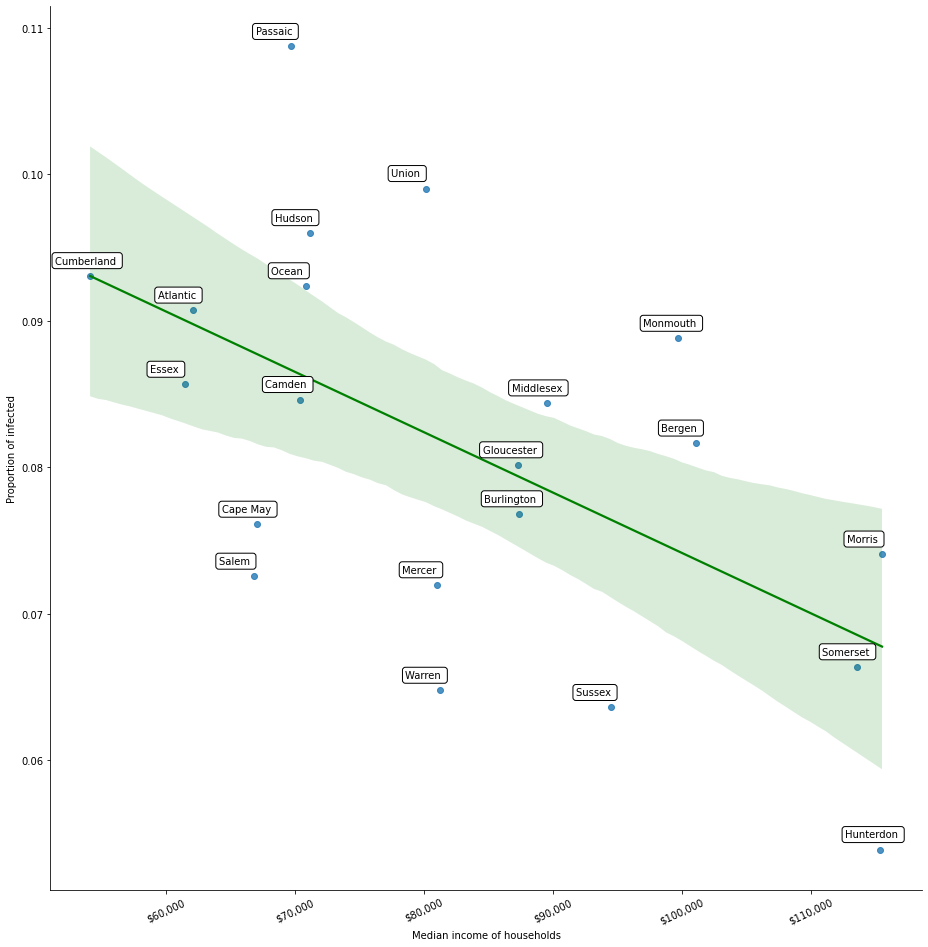

In [39]:
# plot median income against proportion of infected for the 21 counties
lmplot = sns.lmplot(x="Median income", y="Proportional nr. of infected", data=df_proportional_cases_deaths,height=13,line_kws={'color': 'green'})
for i, txt in enumerate(county_name_labels):
    plt.annotate(txt, (median_income[i], proportional_infected[i]),
                 xytext=(-35, 20), textcoords='offset points',
                 bbox=dict(boxstyle="round", fc="w"), va="top")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
for ax in lmplot.axes.flat:
    ax.xaxis.set_major_formatter(tick)
lmplot.set_axis_labels(x_var="Median income of households",y_var="Proportion of infected")
# plt.title('The proportional number of infected as of 1st of march 2021')
plt.xticks(rotation=25)
plt.show()

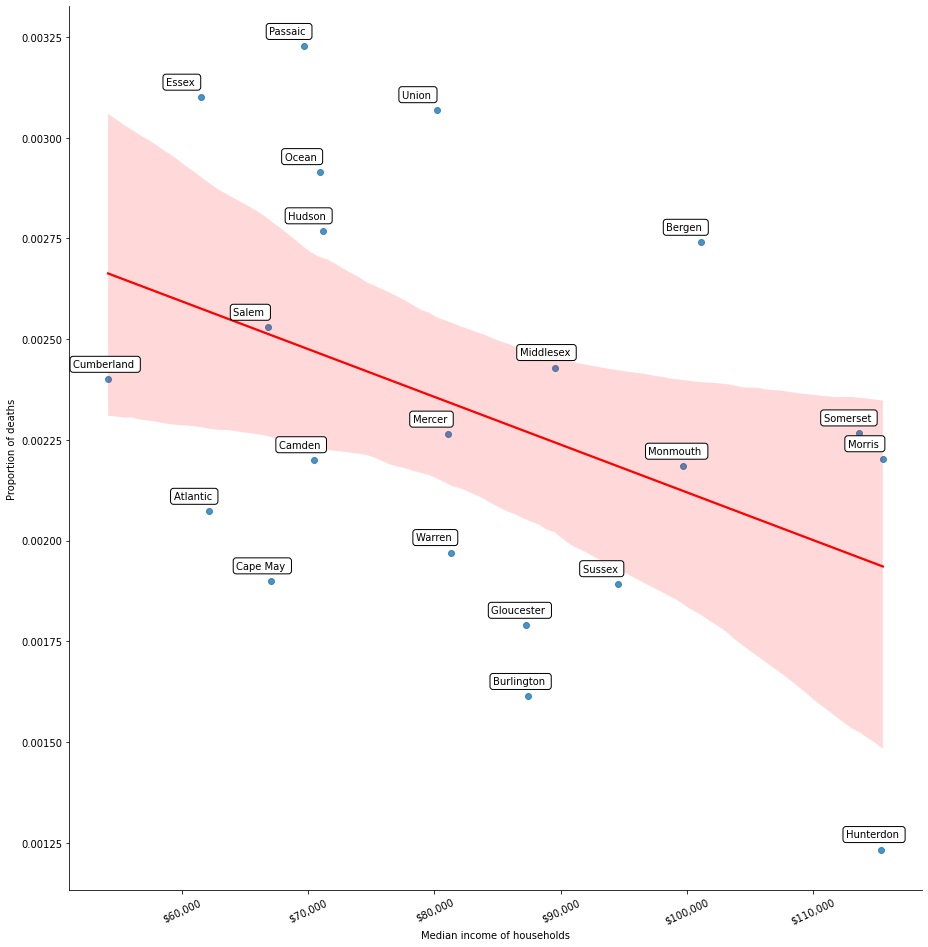

In [40]:
# plotting the proportional deaths against the median income for the 21 counties 
lmplot = sns.lmplot(x="Median income", y="Proportional nr. of deaths", data=df_proportional_cases_deaths,height=13,line_kws={'color': 'red'})

for i, txt in enumerate(county_name_labels):
    plt.annotate(txt, (median_income[i], proportional_deaths[i]),
                 xytext=(-35, 20), textcoords='offset points',
                 bbox=dict(boxstyle="round", fc="w"), va="top")
    
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
for ax in lmplot.axes.flat:
    ax.xaxis.set_major_formatter(tick)

lmplot.set_axis_labels(x_var="Median income of households",y_var="Proportion of deaths")
# plt.title('The proportional number of deaths as of 1st of march 2021')
plt.xticks(rotation=25)
plt.show()

# Comparing richest and poorest county (based of median income) on infection and death rate

In [30]:
# obtain names of richest and poorest county and their respective populations
richest_county = df_socio_economics_subset["County Name"][df_socio_economics_subset["Median household income (in 2019 dollars), 2015-2019"].idxmax()]
poorest_county = df_socio_economics_subset["County Name"][df_socio_economics_subset["Median household income (in 2019 dollars), 2015-2019"].idxmin()]

# get the population of the richest and poorest
richest_county_population = int(df_socio_economics_subset["Population, Census, April 1, 2020"].loc[df_socio_economics_subset["County Name"] == richest_county])
poorest_county_population = int(df_socio_economics_subset["Population, Census, April 1, 2020"].loc[df_socio_economics_subset["County Name"] == poorest_county])

# copy over the cases_deaths dataframe
grouped = df_cases_deaths.sort_values(["County Name","Date"]).reset_index(drop=True).copy()
# create subgroups based of county
grouped = grouped.groupby(grouped["County Name"])

# take the richest and poorest county as groups
df_cases_deaths_richest = grouped.get_group(richest_county).reset_index(drop=True)
df_cases_deaths_poorest = grouped.get_group(poorest_county).reset_index(drop=True)

In [31]:
# unpivot the pivotted table to make it more suitable for plotting
df_infections_pivotted_richest = df_cases_deaths_richest.pivot_table("Nr. of infected",index = "County Name", columns = "Date")
df_infections_pivotted_poorest = df_cases_deaths_poorest.pivot_table("Nr. of infected",index = "County Name", columns = "Date")

# make the subdata proportional and merge
df_infections_pivotted_richest = df_infections_pivotted_richest.div(richest_county_population)
df_infections_pivotted_poorest = df_infections_pivotted_poorest.div(poorest_county_population)

df_infections_pivotted = pd.concat([df_infections_pivotted_richest,df_infections_pivotted_poorest])
for name,group in grouped:
  if not name in [richest_county,poorest_county]:
    temporary_group = group.pivot_table("Nr. of infected",index = "County Name", columns = "Date")
    df_infections_pivotted = df_infections_pivotted.append(temporary_group.div(int(df_socio_economics_subset["Population, Census, April 1, 2020"].loc[df_socio_economics_subset["County Name"] == name])))

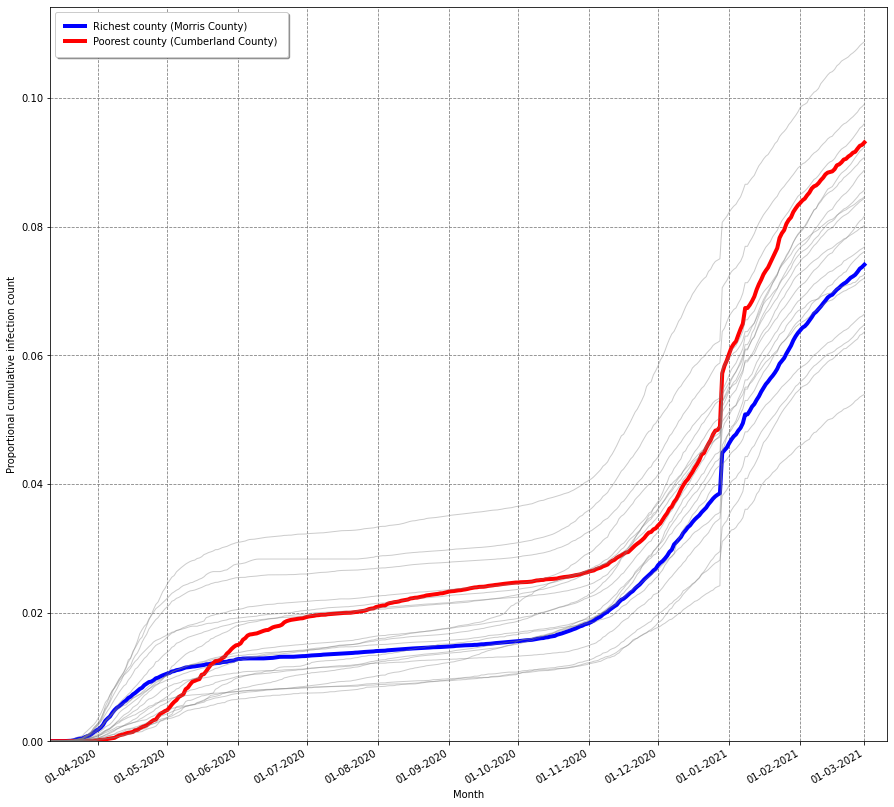

In [42]:
# plotting both counties on a timeplot
fig, ax = plt.subplots(figsize=(15,15))
for county in df_infections_pivotted.index:
  if county == richest_county:
    ax.plot(df_infections_pivotted.loc[richest_county], label = 'Richest county ({})'.format(richest_county), color = "blue", linewidth = 4)
  elif county == poorest_county:
    ax.plot(df_infections_pivotted.loc[poorest_county], label = 'Poorest county ({})'.format(poorest_county), color = "red", linewidth = 4)
  else:
    ax.plot(df_infections_pivotted.loc[county], color="gray", linewidth=1, alpha=0.4)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
leg = ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
# ax.set_title('The proportional cumulative infection per day for the counties in New Jersey')
ax.set_xlabel('Month')
ax.set_xlim([datetime.date(2020, 3, 11), datetime.date(2021, 3, 11)])
ax.set_ylim(ymin=0)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_ylabel('Proportional cumulative infection count')
plt.show()

# Deeper analysis of county-level death and infection rate progression


In [33]:
 # further inspection on the number of infected and deaths

# filter only on last day of month
df_cases_deaths_richest_m = df_cases_deaths_richest[(df_cases_deaths_richest['Date'] >= '2020-03-01')&
                                                  (df_cases_deaths_richest['Date'] <= '2021-03-01')&
                                                  (df_cases_deaths_richest['Date'].dt.is_month_start)]

# swap from integer months to string months
df_cases_deaths_richest_m = df_cases_deaths_richest_m.rename(columns = {"Date": "Month"})
df_cases_deaths_richest_m["Month"] = df_cases_deaths_richest_m["Month"].dt.month_name()

# add daily number of infected and deaths to poorest county
df_cases_deaths_richest_m["Monthly nr. of infected"] = df_cases_deaths_richest_m['Nr. of infected'].diff().fillna(df_cases_deaths_richest_m['Nr. of infected'])
df_cases_deaths_richest_m["Monthly nr. of deaths"] = df_cases_deaths_richest_m['Nr. of deaths'].diff().fillna(df_cases_deaths_richest_m['Nr. of deaths'])



# filter only on last day of month
df_cases_deaths_poorest_m = df_cases_deaths_poorest[(df_cases_deaths_poorest['Date'] >= '2020-03-01')&
                                                  (df_cases_deaths_poorest['Date'] <= '2021-03-01')&
                                                  (df_cases_deaths_poorest['Date'].dt.is_month_start)]

# swap from integer months to string months
df_cases_deaths_poorest_m = df_cases_deaths_poorest_m.rename(columns = {"Date": "Month"})
df_cases_deaths_poorest_m["Month"] = df_cases_deaths_poorest_m["Month"].dt.month_name()

# add daily number of infected and deaths to poorest county
df_cases_deaths_poorest_m["Monthly nr. of infected"] = df_cases_deaths_poorest_m['Nr. of infected'].diff().fillna(df_cases_deaths_poorest_m['Nr. of infected'])
df_cases_deaths_poorest_m["Monthly nr. of deaths"] = df_cases_deaths_poorest_m['Nr. of deaths'].diff().fillna(df_cases_deaths_poorest_m['Nr. of deaths'])



# pivot daily infected table to be able to be used for heatmap
df_monthly_infected_pivotted = pd.concat([df_cases_deaths_richest_m.pivot_table("Monthly nr. of infected",index="County Name",columns="Month"),
                                  df_cases_deaths_poorest_m.pivot_table("Monthly nr. of infected",index="County Name",columns="Month")])

# pivot daily deaths table to be able to be used for heatmap
df_monthly_deaths_pivotted = pd.concat([df_cases_deaths_richest_m.pivot_table("Monthly nr. of deaths",index="County Name",columns="Month"),
                                  df_cases_deaths_poorest_m.pivot_table("Monthly nr. of deaths",index="County Name",columns="Month")])

# obtain remainder counties
for name,group in grouped:
  if not name in [richest_county,poorest_county]:
    # filter only on last day of month
    group = group[(group['Date'] >= '2020-03-01')&(group['Date'] <= '2021-03-01')&(group['Date'].dt.is_month_start)].copy()
    # swap from integer months to string months
    group = group.rename(columns = {"Date": "Month"})
    group["Month"] = group["Month"].dt.month_name()
    group["Monthly nr. of infected"] = group['Nr. of infected'].diff().fillna(group['Nr. of infected'])
    group["Monthly nr. of deaths"] = group['Nr. of deaths'].diff().fillna(group['Nr. of deaths'])
    df_monthly_infected_pivotted = df_monthly_infected_pivotted.append(group.pivot_table("Monthly nr. of infected",index="County Name",columns="Month"))
    df_monthly_deaths_pivotted = df_monthly_deaths_pivotted.append(group.pivot_table("Monthly nr. of deaths",index="County Name",columns="Month"))

# order of months in a list
column_names = ["March", "April", "May", "June", "July", "August","September", "October", "November", "December", "January", "February", "March"]
df_monthly_infected_pivotted = df_monthly_infected_pivotted.sort_index().reindex(columns = column_names)
df_monthly_deaths_pivotted = df_monthly_deaths_pivotted.sort_index().reindex(columns = column_names)

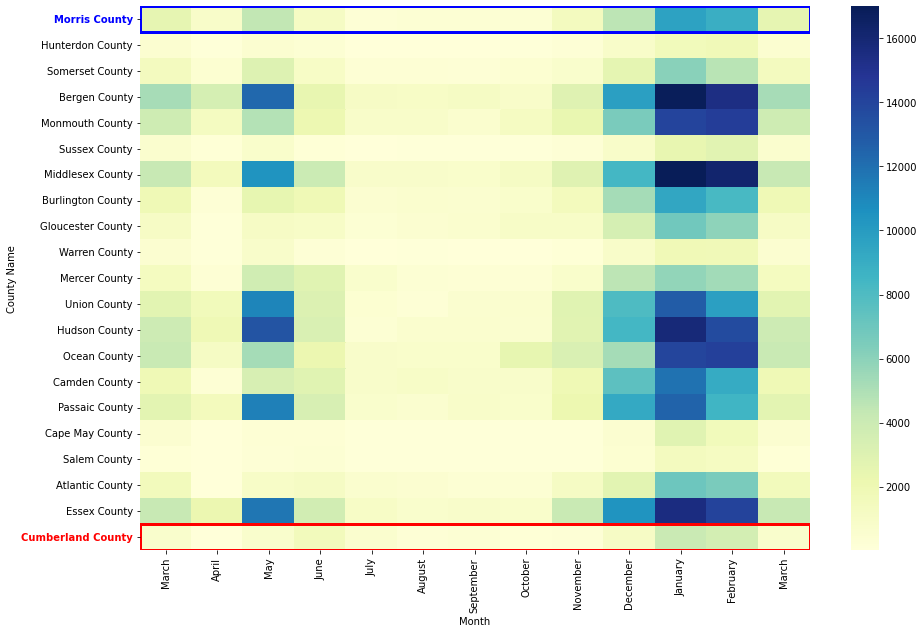

In [43]:
# heatmap for monthly infection rate per county
fig, ax = plt.subplots(figsize=(15,10))

# define the order to be used 
ordering = df_socio_economics_subset.sort_values('Median household income (in 2019 dollars), 2015-2019', ascending = False)['County Name'].reset_index(drop=True)

sns.heatmap(df_monthly_infected_pivotted.loc[ordering],cmap="YlGnBu")
# ax.set_title("Monthly new infections per county in New Jersey (March 2020 - March 2021)")
border_color_rich = "blue"
border_color_poor = "red"
ax.add_patch(plt.Rectangle((0, ordering.tolist().index(richest_county)), len(column_names), 1, fill=False,
edgecolor=border_color_rich, lw=3))
ax.add_patch(plt.Rectangle((0, ordering.tolist().index(poorest_county)), len(column_names), 1, fill=False,
edgecolor=border_color_poor, lw=3))
for lab in ax.get_yticklabels():
    text = lab.get_text()
    if text == richest_county: 
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_rich)
    elif text == poorest_county:
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_poor)
plt.show()

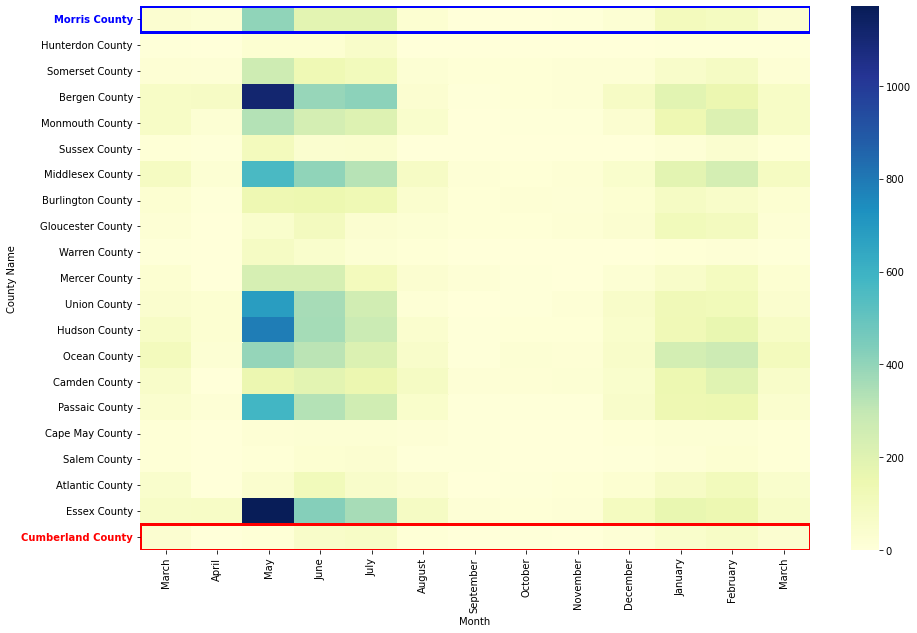

In [44]:
# heatmap for monthly death rate per county
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(df_monthly_deaths_pivotted.loc[ordering],cmap="YlGnBu")

# ax.set_title("Monthly new deaths per county in New Jersey (March 2020 - March 2021)")
border_color_rich = "blue"
border_color_poor = "red"
ax.add_patch(plt.Rectangle((0, ordering.tolist().index(richest_county)), len(column_names), 1, fill=False,
edgecolor=border_color_rich, lw=3))
ax.add_patch(plt.Rectangle((0, ordering.tolist().index(poorest_county)), len(column_names), 1, fill=False,
edgecolor=border_color_poor, lw=3))
for lab in ax.get_yticklabels():
    text = lab.get_text()
    if text == richest_county: 
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_rich)
    elif text == poorest_county:
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_poor)
plt.show()

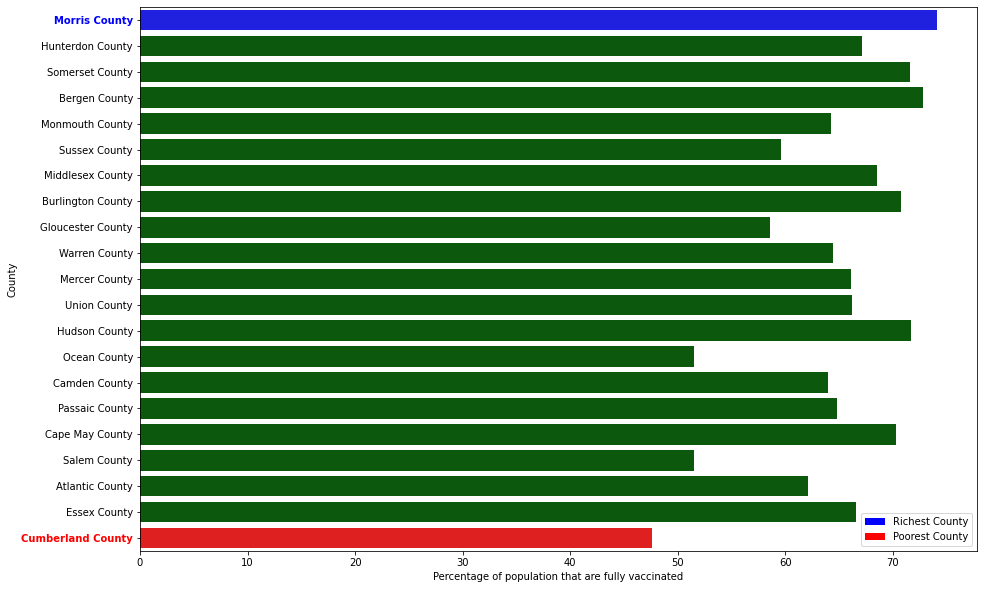

In [45]:
from matplotlib.patches import Patch
# bar plot showing fully vacinated (2-doses) population percentage of each county on/up until the latest date in our vax dataset
fig, ax = plt.subplots(figsize=(15,10))
bar = sns.barplot(y="Recip_County",  x="Series_Complete_Pop_Pct", data=df_vax[df_vax['Date'] == '2021-12-31' ], order = ordering, color='darkgreen')

border_color_rich = "blue"
border_color_poor = "red"
col = [] # create list of colors which makes the richest and poorest counties stand out
for lab in ax.get_yticklabels():
    text = lab.get_text()
    if text == richest_county: 
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_rich)
        col.append(border_color_rich)
    elif text == poorest_county:
        lab.set_weight('bold')
        lab.set_size(10)
        lab.set_color(border_color_poor)
        col.append(border_color_poor)
    else:
      col.append('darkgreen')


bar = sns.barplot(y="Recip_County",  x="Series_Complete_Pop_Pct", data=df_vax[df_vax['Date'] == '2021-12-31' ], order = ordering , palette=col)
# add legend
legend_elements = [Patch(facecolor='blue',
                         label='Richest County'), Patch(facecolor='red',
                         label='Poorest County')]
ax.legend(handles=legend_elements)
# ax.set_title("Completed vaccination (2-doses) rates per county (sorted by median household income) in New Jersey (On 31st December 2021)")
ax.set_xlabel('Percentage of population that are fully vaccinated')
ax.set_ylabel('County')
# show the graph
plt.show()

In [37]:
# strip percent sign and convert education percentage into numeric values

df_socio_economics_subset["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"] = pd.to_numeric(df_socio_economics_subset["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"].str.rstrip('%'))


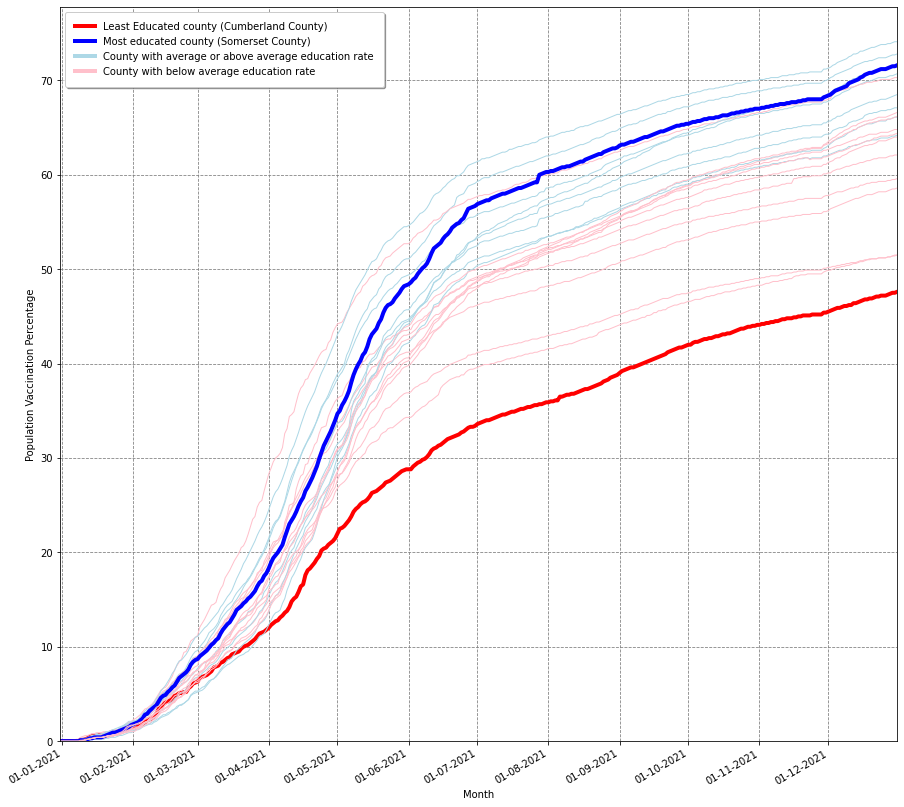

In [46]:
from matplotlib.lines import Line2D
# obtain names of most and least educated counties
highest_edu_county = df_socio_economics_subset["County Name"][df_socio_economics_subset["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"].idxmax()]
lowest_edu_county = df_socio_economics_subset["County Name"][df_socio_economics_subset["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"].idxmin()]
# obtain mean higher education percentage of counties in NJ
mean_edu_NJ = df_socio_economics_subset["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"].mean()
# extract education data for each county
education = df_socio_economics_subset[["Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019"]].set_index(df_socio_economics_subset['County Name'])
# pivot vax dataset for easier plotting
df_vax_pivotted = df_vax.pivot_table("Series_Complete_Pop_Pct",index = "Recip_County", columns = "Date")
# plotting both counties on a timeplot
fig, ax = plt.subplots(figsize=(15,15))
for county in df_vax_pivotted.index:
  if county == highest_edu_county:
    ax.plot(df_vax_pivotted.loc[highest_edu_county], label = 'Most educated county ({})'.format(highest_edu_county), color = "blue", linewidth = 4)
  elif county == lowest_edu_county:
    ax.plot(df_vax_pivotted.loc[lowest_edu_county], label = 'Least Educated county ({})'.format(lowest_edu_county), color = "red", linewidth = 4)
  elif education.loc[county].values[0] >= mean_edu_NJ:
    ax.plot(df_vax_pivotted.loc[county], color="lightblue", linewidth=1)
  else:
    ax.plot(df_vax_pivotted.loc[county], color="pink", linewidth=1)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# manually add legend labels
handles, labels = ax.get_legend_handles_labels()
legend_elements = [Line2D([0], [0], color='lightblue', lw=4, label='County with average or above average education rate'),
                          Line2D([0], [0], color='pink', lw=4, label='County with below average education rate')]
handles = handles + legend_elements
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
leg = ax.legend(handles = handles, fancybox=True, framealpha=1, shadow=True, borderpad=1)
# ax.set_title('The rate of the fully vaccinated population per day for each county (with their education rate highlighted) in the state of New Jersey')
ax.set_xlabel('Month')
ax.set_xlim([datetime.date(2020, 12, 31), datetime.date(2021, 12, 31)])
ax.set_ylim(ymin=0)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_ylabel('Population Vaccination Percentage')
plt.show()